3                         The Dark Knight Rises
299                              Batman Forever
428                              Batman Returns
3854    Batman: The Dark Knight Returns, Part 2
1359                                     Batman
2507                                  Slow Burn
1181                                        JFK
119                               Batman Begins
205          Sherlock Holmes: A Game of Shadows
879                         Law Abiding Citizen
Name: original_title, dtype: object


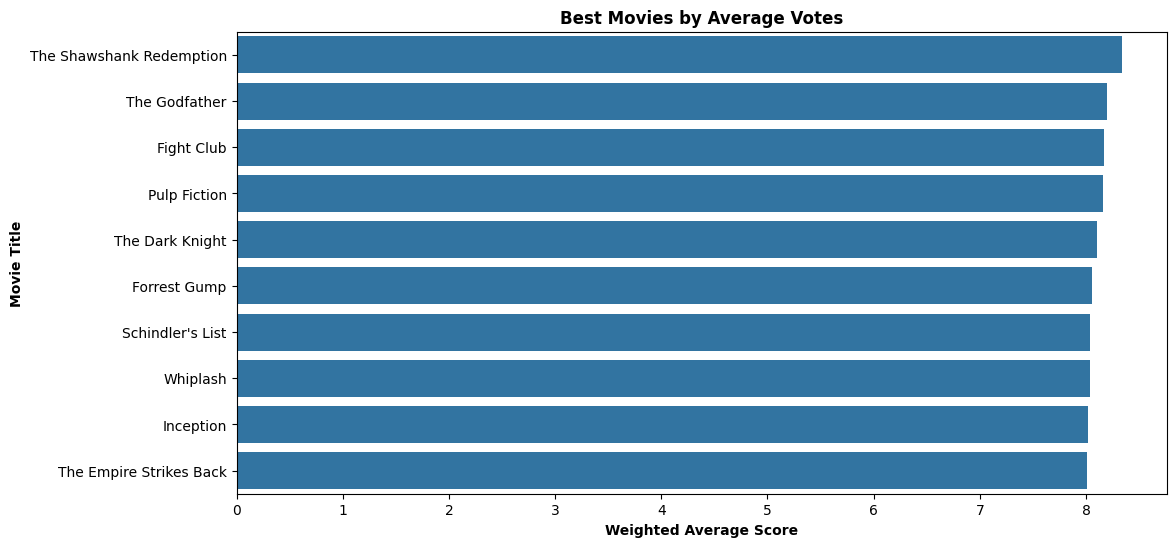

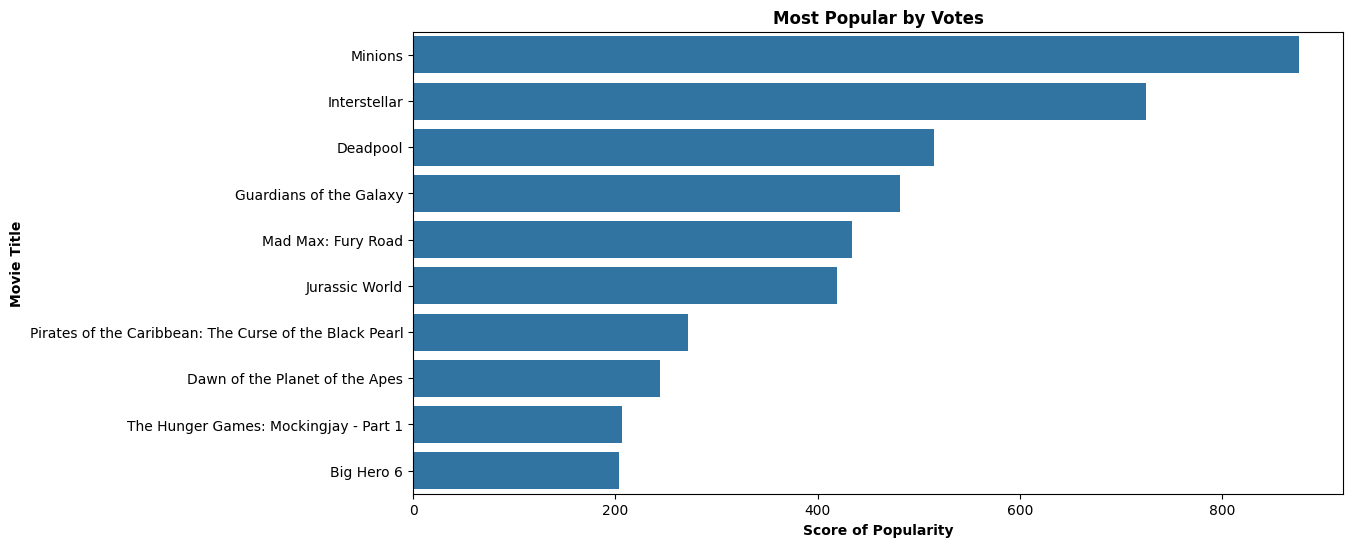

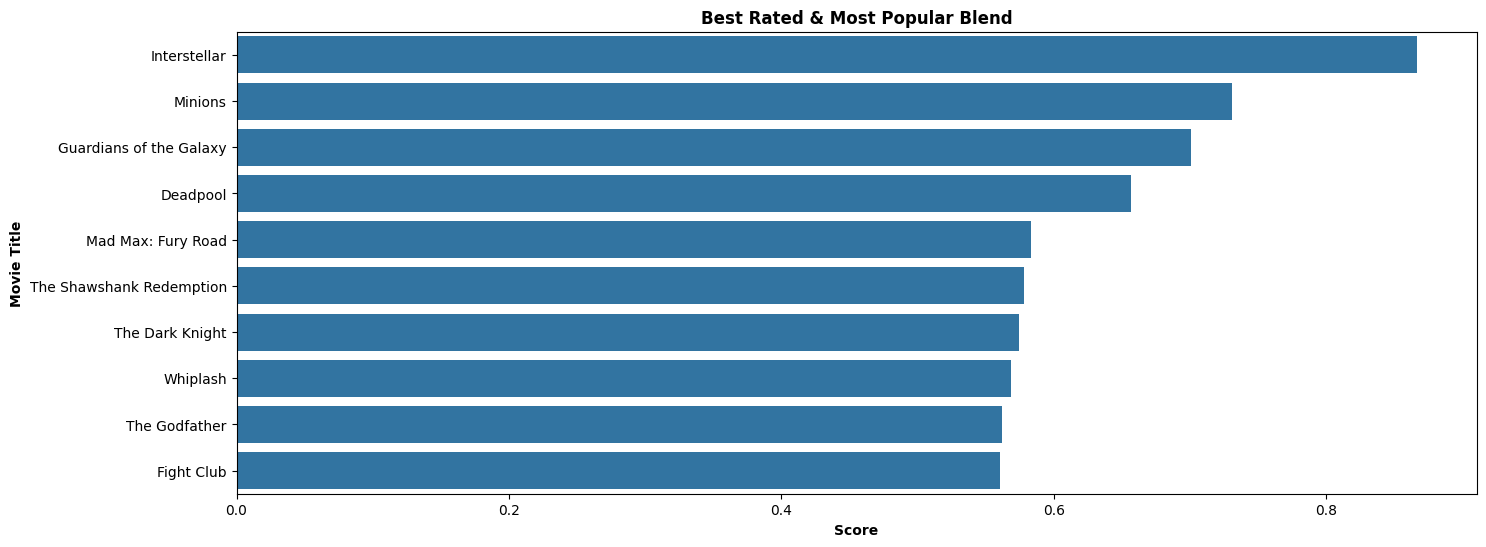

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel

# Load datasets
credits = pd.read_csv("/content/tmdb_5000_credits.csv", on_bad_lines='skip')
movies_df = pd.read_csv("/content/tmdb_5000_movies.csv", on_bad_lines='skip')

# Data Preprocessing
credits_column_renamed = credits.rename(index=str, columns={"movie_id": "id"})
movies_df_merge = movies_df.merge(credits_column_renamed, on='id')
movies_cleaned_df = movies_df_merge.drop(columns=['homepage', 'title_x', 'title_y', 'status','production_countries'])

# Weighted Average Calculation
v = movies_cleaned_df['vote_count']
R = movies_cleaned_df['vote_average']
C = movies_cleaned_df['vote_average'].mean()
m = movies_cleaned_df['vote_count'].quantile(0.70)
movies_cleaned_df['weighted_average'] = ((R*v) + (C*m)) / (v+m)

# Recommendation based on weighted average
movie_sorted_ranking = movies_cleaned_df.sort_values('weighted_average',ascending=False)

# Visualization
plt.figure(figsize=(12,6))
sns.barplot(x=movie_sorted_ranking['weighted_average'].head(10), y=movie_sorted_ranking['original_title'].head(10), data=movie_sorted_ranking)
plt.title('Best Movies by Average Votes', weight='bold')
plt.xlabel('Weighted Average Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')

# Recommendation based on popularity
popularity = movie_sorted_ranking.sort_values('popularity',ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=popularity['popularity'].head(10), y=popularity['original_title'].head(10), data=popularity)
plt.title('Most Popular by Votes', weight='bold')
plt.xlabel('Score of Popularity', weight='bold')
plt.ylabel('Movie Title', weight='bold')

# Scaling weighted average and popularity score
scaling = MinMaxScaler()
movie_scaled_df = scaling.fit_transform(movies_cleaned_df[['weighted_average','popularity']])
movie_normalized_df = pd.DataFrame(movie_scaled_df,columns=['weighted_average','popularity'])
movies_cleaned_df[['normalized_weight_average','normalized_popularity']]= movie_normalized_df
movies_cleaned_df['score'] = movies_cleaned_df['normalized_weight_average'] * 0.5 + movies_cleaned_df['normalized_popularity'] * 0.5
movies_scored_df = movies_cleaned_df.sort_values(['score'], ascending=False)

# Visualization of scored movies
plt.figure(figsize=(16,6))
sns.barplot(x=movies_scored_df['score'].head(10), y=movies_scored_df['original_title'].head(10), data=movies_scored_df)
plt.title('Best Rated & Most Popular Blend', weight='bold')
plt.xlabel('Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')

# Content-Based Recommendation System
tfv = TfidfVectorizer(min_df=3,  max_features=None,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3),
            stop_words = 'english')
movies_cleaned_df['overview'] = movies_cleaned_df['overview'].fillna('')
tfv_matrix = tfv.fit_transform(movies_cleaned_df['overview'])
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)
indices = pd.Series(movies_cleaned_df.index, index=movies_cleaned_df['original_title']).drop_duplicates()

def give_rec(title, sig=sig):
    idx = indices[title]
    sig_scores = list(enumerate(sig[idx]))
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    sig_scores = sig_scores[1:11]
    movie_indices = [i[0] for i in sig_scores]
    return movies_cleaned_df['original_title'].iloc[movie_indices]

# Example usage of content-based recommendation system
print(give_rec('The Dark Knight'))
